# Training a Pizza Slice Angle Detector

In [1]:
## Define imports

## See 'dataloader.py' for custom dataloader class
from dataloader import create_data, PizzaDataset
## See 'model.py' for custom model class
from model import KeypointDetector
## See 'image_transforms.py' for custom image transforms
from image_transforms import *


## Some generic functions
from torchvision import transforms, utils
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.transforms import v2


/home/sandippanesar/anaconda3/envs/llm_env/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/sandippanesar/anaconda3/envs/llm_env/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

## Load Data from SQL Database and Create Train-Test Split

In [2]:
dl = create_data('./data/pizza_database.db','pizza_table')
train, valid = dl.split_data(0.8, ['index','data_path','x1','y1','x2','y2','other'])

## Define Image Transform Pipeline

Uses a combination of custom functions and those from the Torch library.

The rescale function also rescales the label coordinates.

NB: Due to time constraints, I decided to just normalize the image dimensions of each image. In some instances the aspect ratios are altered, which potentially causes a change in the angle of the pizza slice. Given more time, I would work on a solution to this. 

In [3]:
transforms = v2.Compose([
    Rescale((224, 224)),
    Normalize(),
    v2.ToDtype(torch.float32),
])

## Transform Train Dataset

Create both transformed and untransformed datasets.

**Moving forward: x1,y1 is the tip and taken to be the origin point when calculating the angle relative to the vertical i.e. Y-axis**

The intention of both the data loader and the rest of this pipeline allows for **more training data to be added to the SQL database** so the model can be improved. 

Given more training data, batch size could be increased also. 

In [4]:
untransformed_train_dataset = PizzaDataset(train, './data/images')
transformed_train_dataset = PizzaDataset(train, './data/images', transforms)

print(f'Size of Training Dataset: {len(train)}')

train

Size of Training Dataset: 4


,index,data_path,x1,y1,x2,y2,other
0,676378,pizza0.jpg,65,905,108,875,None
1,603024,pizza1.jpg,99,243,99,224,None
2,162132,pizza4.jpg,270,409,325,399,None
3,759454,pizza2.jpg,2694,1586,2544,1484,None


## Visualize Examples

NB: Note Y-axis is flipped when interpreting printed angle. 

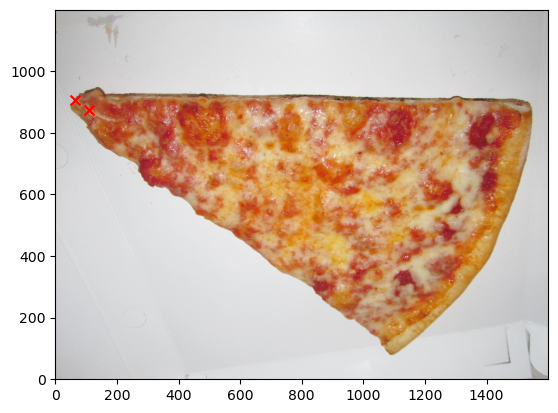

Angle of slice: 132.92996934695887


In [5]:
## Untransformed Image

eg0 = transformed_train_dataset.__getitem__(0)
eg0_u = untransformed_train_dataset.__getitem__(0)

dl.visualize_matrix_with_coordinates(eg0_u['image'], eg0_u['keypoints'])

print(f"Angle of slice: {dl.calculate_clockwise_angle(eg0['keypoints'])}")

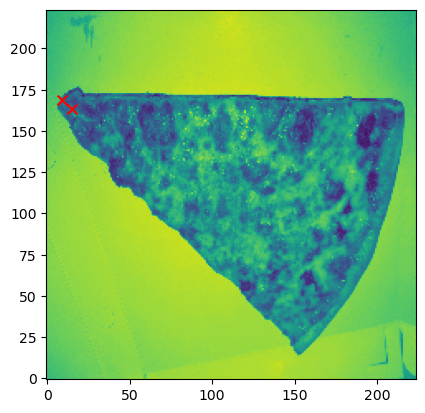

Angle of slice: 124.90249561592474


In [6]:
## Transformed Image

dl.visualize_matrix_with_coordinates(eg0['image'],eg0['keypoints'])

print(f"Angle of slice: {dl.calculate_clockwise_angle(eg0_u['keypoints'])}")

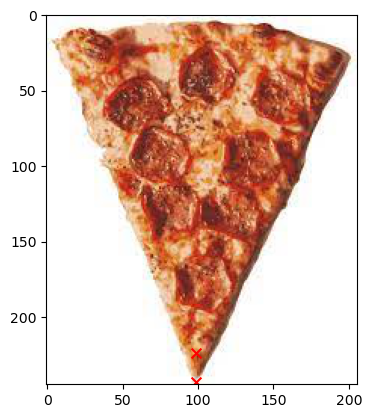

Angle of slice: 180.0


/home/sandippanesar/Desktop/pizza/dataloader.py:123: RuntimeWarning: divide by zero encountered in double_scalars
  m = (points[3] - points[2]) / (points[1] - points[0])


In [7]:
## Untransformed Image

eg1 = transformed_train_dataset.__getitem__(1)
eg1_u = untransformed_train_dataset.__getitem__(1)

dl.visualize_matrix_with_coordinates(eg1_u['image'],eg1_u['keypoints'], flip_y=False)
print(f"Angle of slice: {dl.calculate_clockwise_angle(eg1['keypoints'])}")

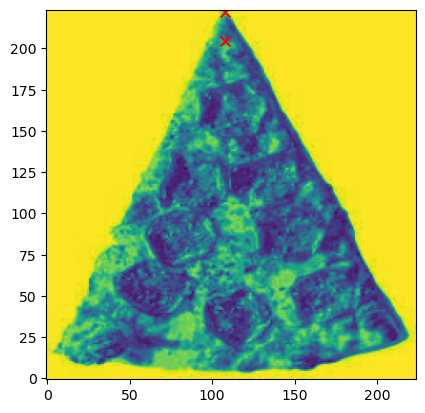

Angle of slice: 180.0


In [8]:
## Transformed Image

dl.visualize_matrix_with_coordinates(eg1['image'],eg1['keypoints'])
print(f"Angle of slice: {dl.calculate_clockwise_angle(eg1_u['keypoints'])}")

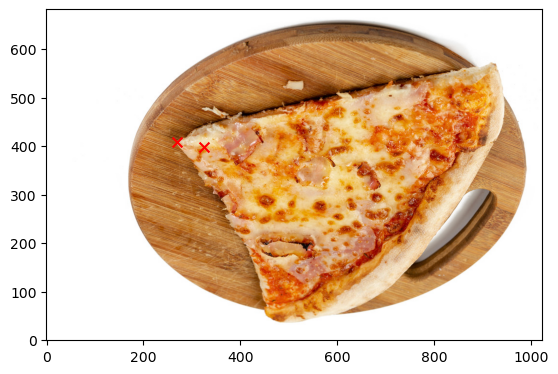

Angle of slice: 105.24802021373586


In [9]:
## Untransformed Image

eg2 = transformed_train_dataset.__getitem__(2)
eg2_u = untransformed_train_dataset.__getitem__(2)

dl.visualize_matrix_with_coordinates(eg2_u['image'],eg2_u['keypoints'])
print(f"Angle of slice: {dl.calculate_clockwise_angle(eg2['keypoints'])}")

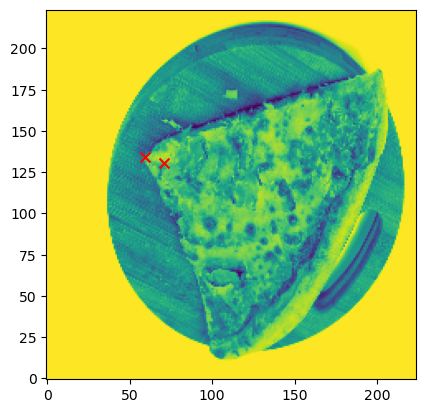

Angle of slice: 105.24802021373586


In [10]:
## Transformed Image

dl.visualize_matrix_with_coordinates(eg2['image'],eg2['keypoints'])
print(f"Angle of slice: {dl.calculate_clockwise_angle(eg2['keypoints'])}")

## Create DataLoader Class For Datasets

In [11]:
train_loader = DataLoader(transformed_train_dataset, batch_size=1, shuffle=True)
transformed_test_dataset = PizzaDataset(valid, './data/images', transforms)
test_loader = DataLoader(transformed_test_dataset, batch_size=1, shuffle=True)

## Define Model Criteria For Training

L1Loss chosen specifically for keypoint detection task, over MSE or other loss functions. 

Has optional dropout layer.

Model 'KeypointDetector' contains: <br>
    - A convolutional layer <br>
    - A dropout layer <br>
    - A max pooling layer <br>
    - Another convolutional layer <br>
    - A dropout layer <br>
    - A fully connected layer <br>
    - Another fully connected layer which outputs an 1x4 array containing keypoint predictions [x1,x2,y1,y2]

Train model for 20 epochs. Might be overfit given size of training dataset. 

In [12]:
criterion = nn.L1Loss()
# device = 'cuda:0'
device = 'cpu'
num_epochs = 20

## Define model with drouput
model = KeypointDetector(use_dropout=True)
model.to(device)
model = model.double()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Define model without dropout
model2 = KeypointDetector(use_dropout=False)
model2.to(device)
model2 = model2.double()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)

## Train Model w/o Dropout

Epoch [1/20], Loss: 144.4762
Epoch [2/20], Loss: 72.1675
Epoch [3/20], Loss: 93.6804
Epoch [4/20], Loss: 63.8277
Epoch [5/20], Loss: 74.3124
Epoch [6/20], Loss: 44.3223
Epoch [7/20], Loss: 54.4706
Epoch [8/20], Loss: 55.0200
Epoch [9/20], Loss: 52.1544
Epoch [10/20], Loss: 48.5876
Epoch [11/20], Loss: 60.3026
Epoch [12/20], Loss: 42.6375
Epoch [13/20], Loss: 46.7932
Epoch [14/20], Loss: 48.9535
Epoch [15/20], Loss: 43.0898
Epoch [16/20], Loss: 44.5996
Epoch [17/20], Loss: 42.0674
Epoch [18/20], Loss: 51.1178
Epoch [19/20], Loss: 40.1112
Epoch [20/20], Loss: 70.7763
Finished Training


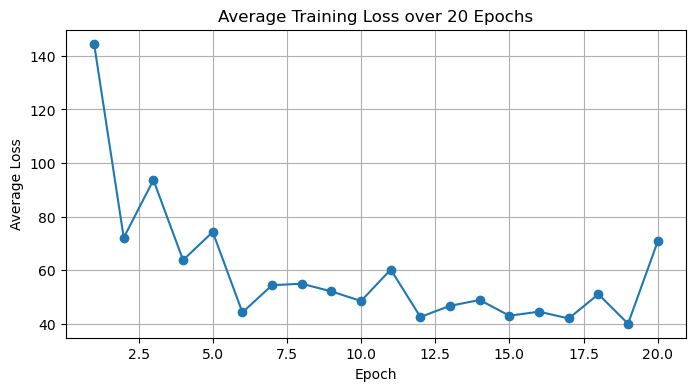

In [13]:
model.train_model(train_loader, criterion, optimizer, num_epochs, device)

## Train Model w/ Dropout

Epoch [1/20], Loss: 133.3856
Epoch [2/20], Loss: 77.6829
Epoch [3/20], Loss: 102.0402
Epoch [4/20], Loss: 76.0591
Epoch [5/20], Loss: 54.7393
Epoch [6/20], Loss: 47.0420
Epoch [7/20], Loss: 51.7843
Epoch [8/20], Loss: 52.8233
Epoch [9/20], Loss: 44.8576
Epoch [10/20], Loss: 44.1067
Epoch [11/20], Loss: 51.3694
Epoch [12/20], Loss: 42.2044
Epoch [13/20], Loss: 51.8401
Epoch [14/20], Loss: 51.4077
Epoch [15/20], Loss: 44.0286
Epoch [16/20], Loss: 38.4707
Epoch [17/20], Loss: 34.0659
Epoch [18/20], Loss: 29.4441
Epoch [19/20], Loss: 30.8783
Epoch [20/20], Loss: 33.0962
Finished Training


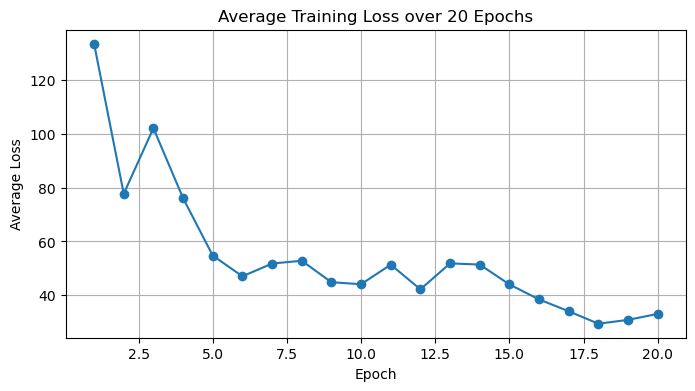

In [14]:
model2.train_model(train_loader, criterion, optimizer2, num_epochs, device)

## Run Evaluation on Validation Set

In [19]:
e1 = model.evaluate_model(model, test_loader, criterion, device)
e2 = model.evaluate_model(model2, test_loader, criterion, device)

print(f'Performance of first model on test dataset (average loss): {e1}')
print('-'*50)
print(f'Performance of second model on test dataset (average loss): {e2}')

Performance of first model on test dataset (average loss): 44.73495858282969
--------------------------------------------------
Performance of second model on test dataset (average loss): 54.031345866847374


## Visualize the Predictions

In [20]:
test_0 = transformed_test_dataset.__getitem__(0)
m1_preds = model.predict(model, test_0['image'])
m2_preds = model.predict(model2, test_0['image'])

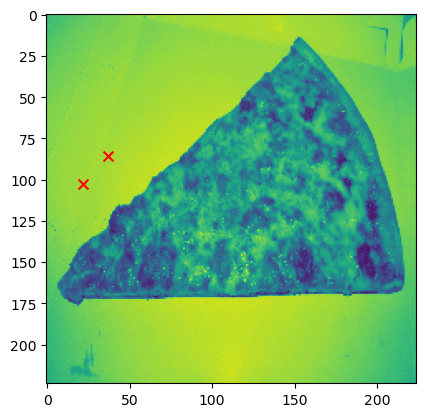

Angle of slice: 137.75217896963937


In [23]:
## Model 1

dl.visualize_matrix_with_coordinates(test_0['image'],m1_preds, flip_y=False)

print(f"Angle of slice: {dl.calculate_clockwise_angle(m1_preds)}")

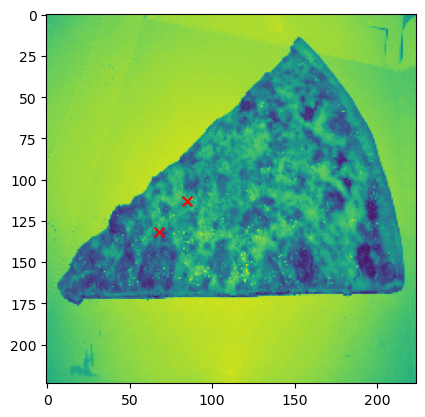

Angle of slice: 138.44840610886317


In [24]:
## Model 2

dl.visualize_matrix_with_coordinates(test_0['image'],m2_preds, flip_y=False)

print(f"Angle of slice: {dl.calculate_clockwise_angle(m2_preds)}")

## Conclusions

- Both models perform generally the same.
- On the test dataset the predicted angle is somewhat correct, despite the keypoints not being correct. 


## Improvements

- Larger training set.
- Devise another method to scale the images so that the angle is preserved despite the aspect ratio being tweaked. 
- Potentially exploring different model architectures, pretrained models e.g. ResNet-50 etc. 